# Data Exploration and Parsing Analysis

This notebook explores the synthetic transaction logs dataset and tests our robust parser implementation.

## Objectives:
1. Load and explore the raw dataset
2. Test the log parser on various formats
3. Analyze parsing success rates and data quality
4. Create visualizations for data understanding

In [1]:
import sys
import os
sys.path.append('/Users/m1pro/Documents/GitHub/fraud_detection_system') # Adjust the path as necessary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from src.parser.log_parser import TransactionLogParser
from src.utils.config import config
from src.utils.visualization import viz

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All imports successful!")
print(f"Configuration loaded: {config.get('data.input_file')}")

IndentationError: unexpected unindent (log_parser.py, line 222)

## 1. Load and Explore Raw Dataset

In [ ]:
# Load raw data
data_file = '../synthetic_dirty_transaction_logs.csv'
df_raw = pd.read_csv(data_file)  # names=['line_num', 'raw_log']

print(f"📊 Dataset Overview:")
print(f"Total entries: {len(df_raw):,}")
print(f"Columns: {list(df_raw.columns)}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic statistics
print("\n📈 Raw Data Info:")
print(df_raw.info())

📊 Dataset Overview:
Total entries: 10,000
Columns: ['raw_log']
Memory usage: 1.37 MB

📈 Raw Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   raw_log  8876 non-null   object
dtypes: object(1)
memory usage: 78.2+ KB
None


In [ ]:
# Sample different types of log entries
print("🔍 Sample Log Entries:")
print("=" * 80)

# Get non-null, non-empty entries
valid_logs = df_raw[df_raw['raw_log'].notna() & 
                   (df_raw['raw_log'] != '""') & 
                   (df_raw['raw_log'] != 'MALFORMED_LOG')]['raw_log']

# Show first 10 valid log entries to understand formats
for i, log_entry in enumerate(valid_logs.head(10), 1):
    print(f"{i:2d}. {log_entry}")
    
print("\n" + "=" * 80)

🔍 Sample Log Entries:
 1. 2025-07-05 19:18:10::user1069::withdrawal::2995.12::London::iPhone 13
 2. usr:user1076|cashout|€4821.85|Glasgow|2025-07-15 12:56:05|Pixel 6
 3. 2025-07-20 05:38:14 >> [user1034] did top-up - amt=€2191.06 - None // dev:iPhone 13
 4. 2025-06-13 10:04:51 >> [user1068] did deposit - amt=€1691.09 - Glasgow // dev:None
 5. 2025-07-29 23:47:37 | user: user1014 | txn: deposit of £3539.5 from Glasgow | device: iPhone 13
 6. 2025-06-23 14:45:58 - user=user1075 - action=debit $1215.74 - ATM: Leeds - device=Samsung Galaxy S10
 7. 2025-07-31 06:50:50 | user: user1071 | txn: cashout of $1772.13 from None | device: Nokia 3310
 8. 2025-07-07 20:42:12 - user=user1098 - action=deposit €304.0 - ATM: Birmingham - device=Nokia 3310
 9. 24/07/2025 22:47:06 ::: user1080 *** PURCHASE ::: amt:951.85$ @ Liverpool <Xiaomi Mi 11>
10. 2025-06-10 20:06:30 >> [user1025] did withdrawal - amt=€3261.07 - London // dev:iPhone 13



In [ ]:
# Analyze log entry patterns
print("📋 Log Entry Pattern Analysis:")
print("=" * 50)

# Count different patterns
pattern_counts = {
    'Empty ("")': len(df_raw[df_raw['raw_log'] == '""']),
    'Malformed': len(df_raw[df_raw['raw_log'] == 'MALFORMED_LOG']),
    'Null/NaN': len(df_raw[df_raw['raw_log'].isna()]),
    'With |': len(df_raw[df_raw['raw_log'].str.contains('\|', na=False)]),
    'With ::': len(df_raw[df_raw['raw_log'].str.contains('::', na=False)]),
    'With >>>': len(df_raw[df_raw['raw_log'].str.contains('>>', na=False)]),
    'With :::': len(df_raw[df_raw['raw_log'].str.contains(':::', na=False)]),
    'With usr:': len(df_raw[df_raw['raw_log'].str.contains('usr:', na=False)]),
    'Space separated': len(df_raw[df_raw['raw_log'].str.startswith('user', na=False)])
}

for pattern, count in pattern_counts.items():
    percentage = (count / len(df_raw)) * 100
    print(f"{pattern:15s}: {count:5d} ({percentage:5.1f}%)")

print(f"\nTotal valid logs: {len(valid_logs):,}")

📋 Log Entry Pattern Analysis:
Empty ("")     :     0 (  0.0%)
Malformed      :  1102 ( 11.0%)
Null/NaN       :  1124 ( 11.2%)
With |         :  2257 ( 22.6%)
With ::        :  2230 ( 22.3%)
With >>>       :  1066 ( 10.7%)
With :::       :  1121 ( 11.2%)
With usr:      :  1119 ( 11.2%)
Space separated:  1132 ( 11.3%)

Total valid logs: 7,774


## 2. Test Log Parser

In [ ]:
# Initialize parser
parser = TransactionLogParser()
print("🔧 Parser initialized successfully!")

# Test parser on sample entries
print("\n🧪 Testing Parser on Sample Entries:")
print("=" * 80)

test_entries = [
    "2025-07-05 19:18:10::user1069::withdrawal::2995.12::London::iPhone 13",
    "usr:user1076|cashout|€4821.85|Glasgow|2025-07-15 12:56:05|Pixel 6",
    "2025-07-20 05:38:14 >> [user1034] did top-up - amt=€2191.06 - None // dev:iPhone 13",
    "13/07/2025 14:53:36 ::: user1048 *** TOP-UP ::: amt:3248.15£ @ Manchester <iPhone 13>",
    "2025-06-23 14:45:58 - user=user1075 - action=debit $1215.74 - ATM: Leeds - device=Samsung Galaxy S10"
]

for i, entry in enumerate(test_entries, 1):
    print(f"\nTest {i}:")
    print(f"Raw: {entry}")
    
    result = parser.parse_log_entry(entry)
    print(f"Parsed: {result.is_parsed}")
    
    if result.is_parsed:
        print(f"  User: {result.user_id}")
        print(f"  Type: {result.transaction_type}")
        print(f"  Amount: {result.currency}{result.amount}")
        print(f"  Location: {result.location}")
        print(f"  Device: {result.device}")
        print(f"  Timestamp: {result.timestamp}")
    else:
        print(f"  Errors: {result.parse_errors}")

🔧 Parser initialized successfully!

🧪 Testing Parser on Sample Entries:

Test 1:
Raw: 2025-07-05 19:18:10::user1069::withdrawal::2995.12::London::iPhone 13
Parsed: True
  User: user1069
  Type: withdrawal
  Amount: None2995.12
  Location: London
  Device: iPhone 13
  Timestamp: 2025-07-05 19:18:10

Test 2:
Raw: usr:user1076|cashout|€4821.85|Glasgow|2025-07-15 12:56:05|Pixel 6
Parsed: True
  User: user1076
  Type: cashout
  Amount: €4821.85
  Location: Glasgow
  Device: Pixel 6
  Timestamp: 2025-07-15 12:56:05

Test 3:
Raw: 2025-07-20 05:38:14 >> [user1034] did top-up - amt=€2191.06 - None // dev:iPhone 13
Parsed: True
  User: user1034
  Type: top
  Amount: €2191.06
  Location: amt=€2191.06 - None
  Device: iPhone 13
  Timestamp: 2025-07-20 05:38:14

Test 4:
Raw: 13/07/2025 14:53:36 ::: user1048 *** TOP-UP ::: amt:3248.15£ @ Manchester <iPhone 13>
Parsed: True
  User: user1048
  Type: top
  Amount: None3248.15
  Location: Manchester
  Device: iPhone 13
  Timestamp: 2025-07-13 14:53:36



## 3. Parse Complete Dataset

In [ ]:
# Parse the complete dataset
print("🚀 Parsing complete dataset...")
print("This may take a few minutes...")

df_parsed, parsing_stats = parser.parse_dataset(data_file)

print("\n✅ Parsing Complete!")
print("=" * 50)
print(f"Total logs processed: {parsing_stats['total_logs']:,}")
print(f"Successfully parsed: {parsing_stats['parsed_successfully']:,}")
print(f"Parsing failed: {parsing_stats['parsing_failed']:,}")
print(f"Empty logs: {parsing_stats['empty_logs']:,}")
print(f"Malformed logs: {parsing_stats['malformed_logs']:,}")

success_rate = (parsing_stats['parsed_successfully'] / parsing_stats['total_logs']) * 100
print(f"\n📈 Overall Success Rate: {success_rate:.1f}%")

INFO:src.parser.log_parser:Starting to parse dataset: ../synthetic_dirty_transaction_logs.csv
INFO:src.parser.log_parser:Processing 10000 log entries...


🚀 Parsing complete dataset...
This may take a few minutes...
10000


INFO:src.parser.log_parser:Parsing complete. Successfully parsed: 7774, Failed: 0, Empty/Malformed: 2226



✅ Parsing Complete!
Total logs processed: 10,000
Successfully parsed: 7,774
Parsing failed: 0
Empty logs: 1,124
Malformed logs: 1,102

📈 Overall Success Rate: 77.7%


In [ ]:
# Display comprehensive parsing statistics
print("\n" + "="*80)
print("📊 COMPREHENSIVE PARSING STATISTICS")
print("="*80)
parser.print_parsing_statistics(parsing_stats)

# Export detailed statistics report
parser.export_statistics_report(parsing_stats, '../results/detailed_parsing_report.json')
print("\n💾 Detailed parsing report saved to results/detailed_parsing_report.json")

# Create and display summary table
summary_table = parser.get_parsing_summary_table(parsing_stats)
print("\n📋 Parsing Summary Table:")
print(summary_table.to_string(index=False))

# Display parsed data overview
print("\n📊 Parsed Dataset Overview:")
print(df_parsed.info())

print("\n🎯 Successfully Parsed Data:")
df_valid = df_parsed[df_parsed['is_parsed'] == True]
print(f"Valid transactions: {len(df_valid):,}")
print(f"Date range: {df_valid['timestamp'].min()} to {df_valid['timestamp'].max()}")
print(f"Unique users: {df_valid['user_id'].nunique():,}")
print(f"Transaction types: {df_valid['transaction_type'].nunique()}")
print(f"Unique locations: {df_valid['location'].nunique()}")
print(f"Unique devices: {df_valid['device'].nunique()}")

INFO:src.parser.log_parser:Parsing statistics report exported to: ../results/detailed_parsing_report.json



📊 COMPREHENSIVE PARSING STATISTICS

📊 TRANSACTION LOG PARSING STATISTICS

📋 PARSING SUMMARY:
  Total Logs Processed: 10,000
  Successfully Parsed:  7,774 (77.74%)
  Parsing Failures:     0 (0.0%)
  Empty Logs:           1,124 (11.24%)
  Malformed Logs:       1,102 (11.02%)

🎯 QUALITY METRICS:
  Parsing Efficiency:   Medium
  Data Quality:         Fair
  Usable Data Ratio:    77.74%

❌ ERROR ANALYSIS:
  Total Errors:         2,226
  - Parsing Errors:     0
  - Empty Entries:      1,124
  - Malformed Entries:  1,102

🔧 FORMAT ANALYSIS:
  Strategy: Sequential format matching with regex fallback
  Complexity: Multiple formats detected - parser handles 7+ different log structures
  Supported Formats: 7 different structures

💡 RECOMMENDATIONS:
  1. Parsing performance is within acceptable ranges
  2. Monitor trends over time for any degradation

📈 PARSING COMPLETE

💾 Detailed parsing report saved to results/detailed_parsing_report.json

📋 Parsing Summary Table:
           Category  Count Pe

## 4. Data Quality Analysis

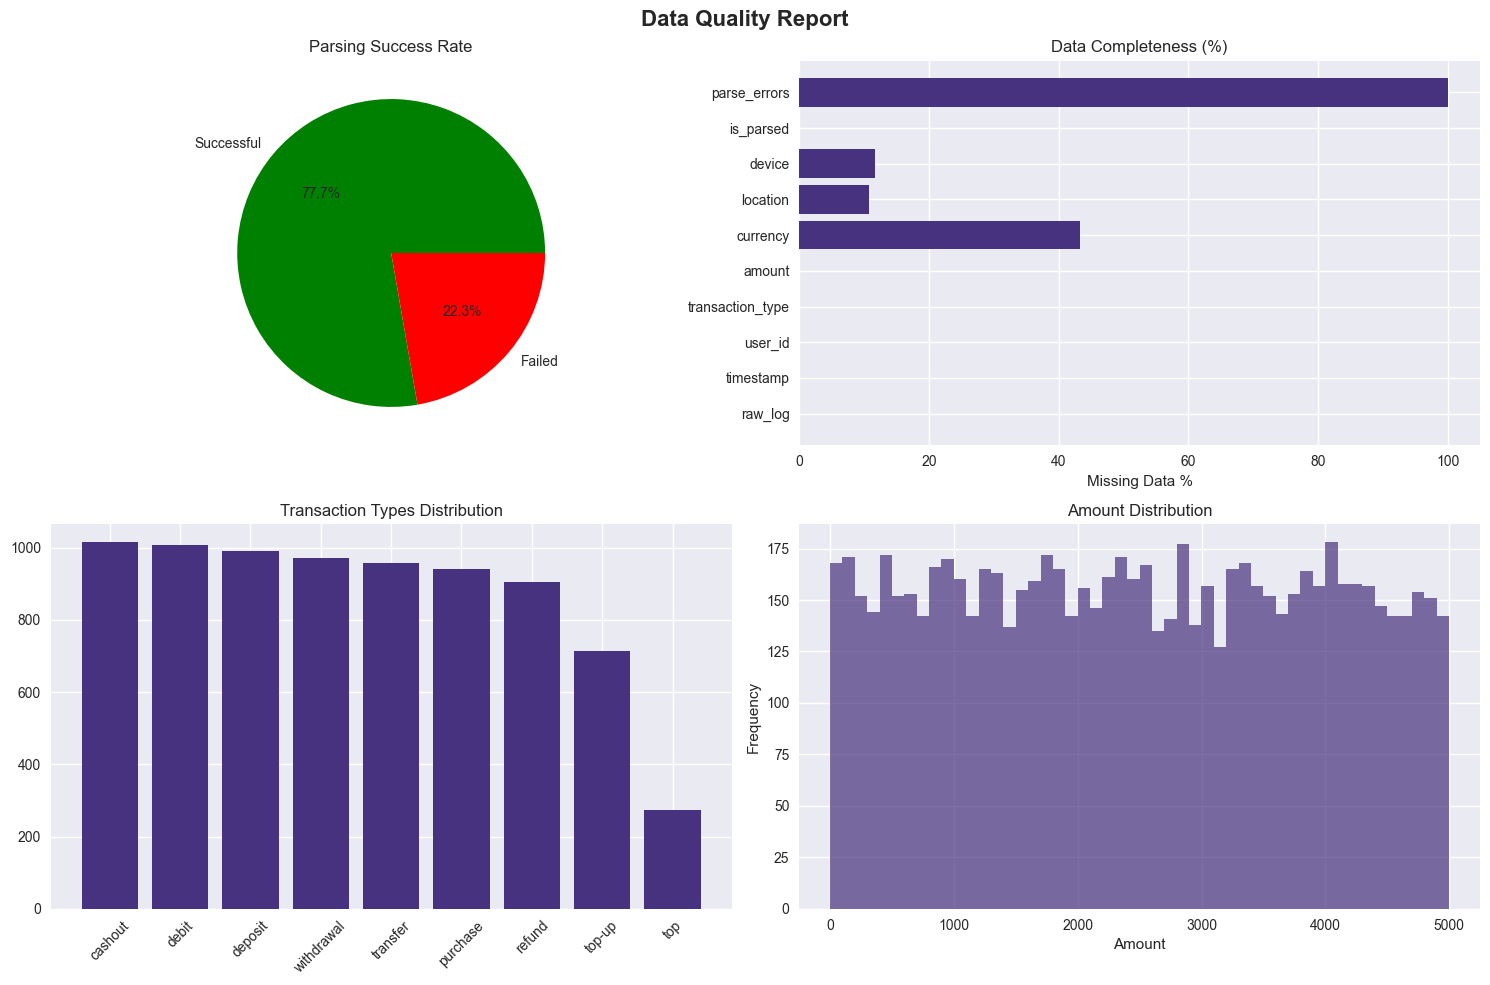

💾 Data quality report saved to results/data_quality_report.png


In [ ]:
# Create data quality visualization
fig = viz.plot_data_quality_report(df_valid, parsing_stats)
plt.show()

# Save the figure
fig.savefig('../results/data_quality_report.png', dpi=300, bbox_inches='tight')
print("💾 Data quality report saved to results/data_quality_report.png")

In [ ]:
# Detailed data completeness analysis
print("🔍 Data Completeness Analysis:")
print("=" * 40)

completeness = {}
for col in ['timestamp', 'user_id', 'transaction_type', 'amount', 'currency', 'location', 'device']:
    non_null = df_valid[col].notna().sum()
    total = len(df_valid)
    completeness[col] = (non_null / total) * 100
    print(f"{col:16s}: {non_null:5d}/{total:5d} ({completeness[col]:.1f}%)")

print(f"\nOverall completeness score: {np.mean(list(completeness.values())):.1f}%")

🔍 Data Completeness Analysis:
timestamp       :  7774/ 7774 (100.0%)
user_id         :  7774/ 7774 (100.0%)
transaction_type:  7774/ 7774 (100.0%)
amount          :  7774/ 7774 (100.0%)
currency        :  4412/ 7774 (56.8%)
location        :  6933/ 7774 (89.2%)
device          :  6860/ 7774 (88.2%)

Overall completeness score: 90.6%


In [ ]:
# Transaction type distribution
print("💳 Transaction Type Distribution:")
type_counts = df_valid['transaction_type'].value_counts()
print(type_counts)

# Currency distribution
print("\n💰 Currency Distribution:")
currency_counts = df_valid['currency'].value_counts()
print(currency_counts)

# Location distribution
print("\n🌍 Location Distribution:")
location_counts = df_valid['location'].value_counts()
print(location_counts)

💳 Transaction Type Distribution:
transaction_type
cashout       1015
debit         1007
deposit        991
withdrawal     971
transfer       958
purchase       940
refund         905
top-up         713
top            274
Name: count, dtype: int64

💰 Currency Distribution:
currency
€    1501
$    1456
£    1455
Name: count, dtype: int64

🌍 Location Distribution:
location
Leeds                        873
London                       850
Glasgow                      843
Manchester                   830
Cardiff                      828
                            ... 
amt=$4355.97 - Manchester      1
amt=€2216.49 - Birmingham      1
amt=€2668.31 - London          1
amt=£3895.4 - Birmingham       1
amt=£4203.63 - London          1
Name: count, Length: 1073, dtype: int64


In [ ]:
df_valid.tail(40)

,raw_log,timestamp,user_id,transaction_type,amount,currency,location,device,is_parsed,parse_errors,hour,day_of_week,is_weekend
7734,user1005 2025-06-12 19:58:45 withdrawal 2869.4...,2025-06-12 19:58:45,user1005,withdrawal,2869.40,None,Liverpool,Pixel,True,None,19,3,False
7735,06/07/2025 11:14:52 ::: user1098 *** TRANSFER ...,2025-07-06 11:14:52,user1098,transfer,594.77,None,Birmingham,Samsung Galaxy S10,True,None,11,6,True
7736,user1033 2025-07-16 17:37:02 debit 647.95 Lond...,2025-07-16 17:37:02,user1033,debit,647.95,None,London,Xiaomi,True,None,17,2,False
7737,usr:user1005|withdrawal|$1203.29|Glasgow|2025-...,2025-07-16 21:22:54,user1005,withdrawal,1203.29,$,Glasgow,Xiaomi Mi 11,True,None,21,2,False
7738,user1021 2025-06-26 02:47:48 withdrawal 4740.9...,2025-06-26 02:47:48,user1021,withdrawal,4740.96,None,Glasgow,iPhone,True,None,2,3,False
7739,02/07/2025 16:14:50 ::: user1011 *** REFUND ::...,2025-07-02 16:14:50,user1011,refund,4715.81,None,Leeds,Xiaomi Mi 11,True,None,16,2,False
7740,2025-06-13 10:35:01 - user=user1014 - action=r...,2025-06-13 10:35:01,user1014,refund,678.99,€,Manchester,None,True,None,10,4,False
7741,usr:user1098|purchase|€2260.45|London|2025-06-...,2025-06-20 01:53:57,user1098,purchase,2260.45,€,London,iPhone 13,True,None,1,4,False
7742,2025-06-15 14:34:49 | user: user1065 | txn: de...,2025-06-15 14:34:49,user1065,debit,14.52,€,None,Xiaomi Mi 11,True,None,14,6,True
7743,24/06/2025 14:45:08 ::: user1003 *** TOP-UP ::...,2025-06-24 14:45:08,user1003,top,3338.15,None,Cardiff,Pixel 6,True,None,14,1,False


In [ ]:
df_valid['location'].unique()

array(['London', 'Glasgow', 'amt=€2191.06 - None', ...,
       'amt=£4537.31 - None', 'amt=$1392.89 - Manchester',
       'amt=£4203.63 - London'], dtype=object)

## 5. Temporal Analysis

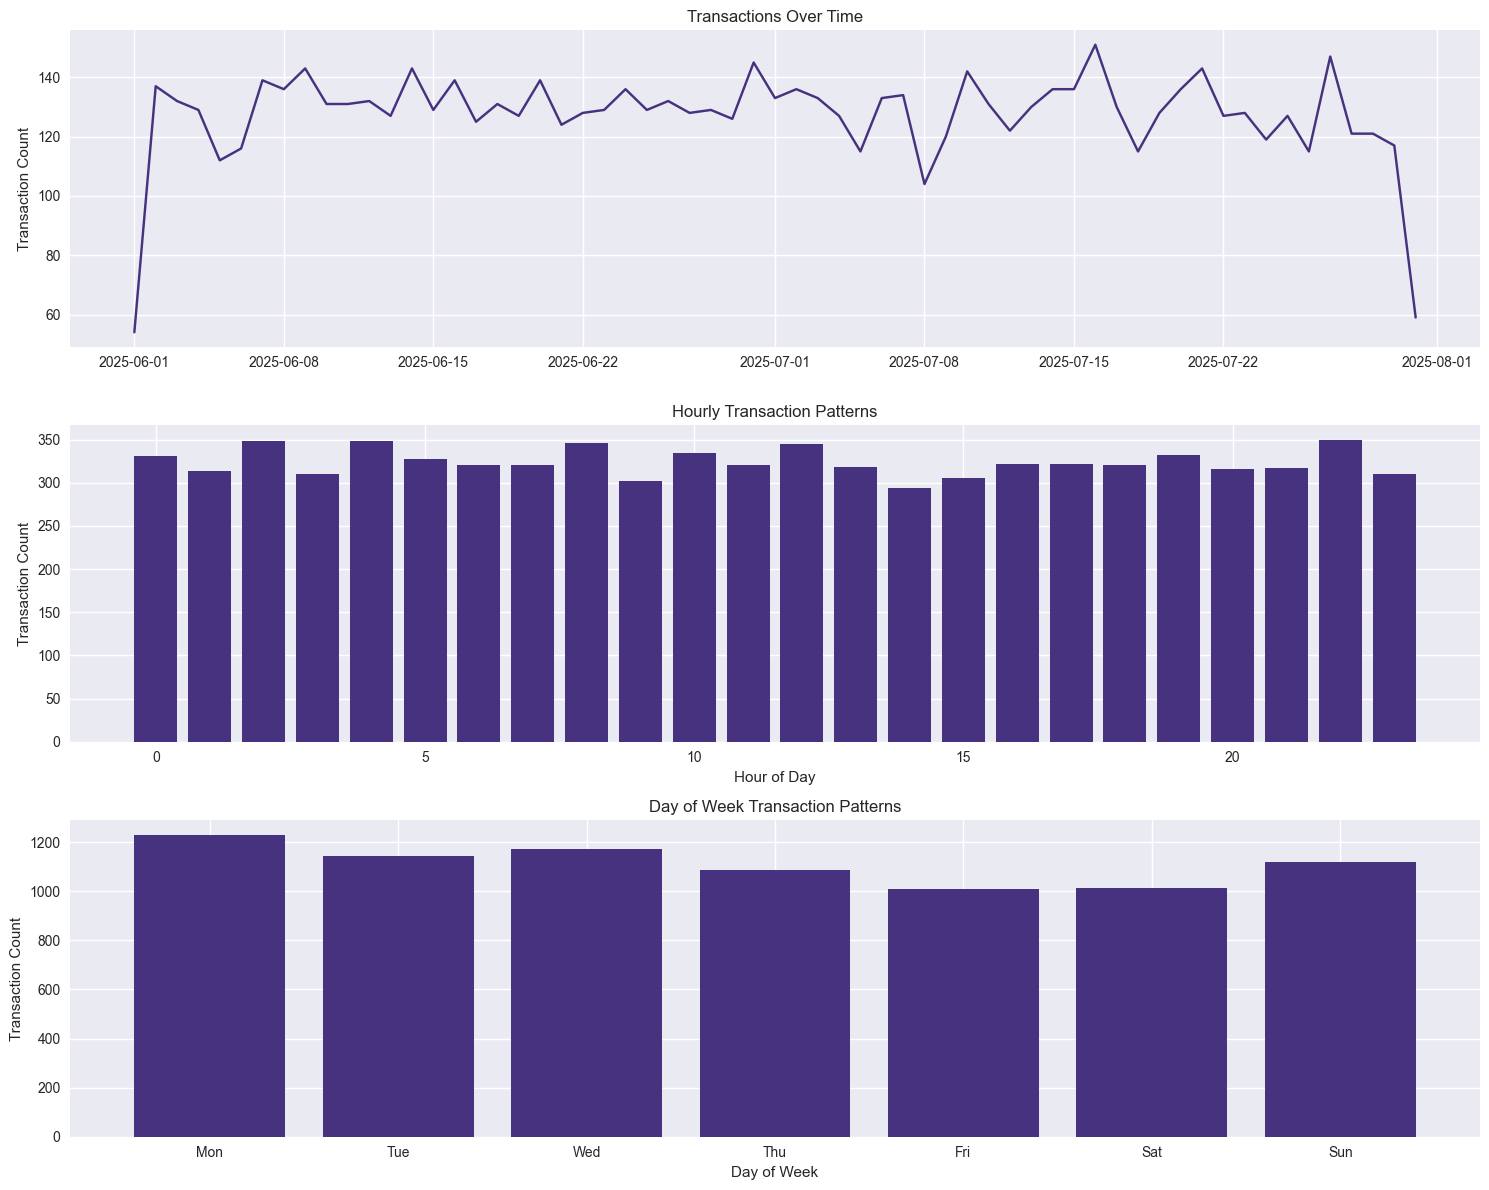

💾 Temporal patterns saved to results/temporal_patterns.png


In [ ]:
# Add temporal features
df_valid = df_valid.copy()
df_valid['hour'] = df_valid['timestamp'].dt.hour
df_valid['day_of_week'] = df_valid['timestamp'].dt.dayofweek
df_valid['is_weekend'] = df_valid['day_of_week'].isin([5, 6])

# Plot temporal patterns
fig = viz.plot_temporal_patterns(df_valid)
plt.show()

# Save the figure
fig.savefig('../results/temporal_patterns.png', dpi=300, bbox_inches='tight')
print("💾 Temporal patterns saved to results/temporal_patterns.png")

## 6. User Behavior Analysis

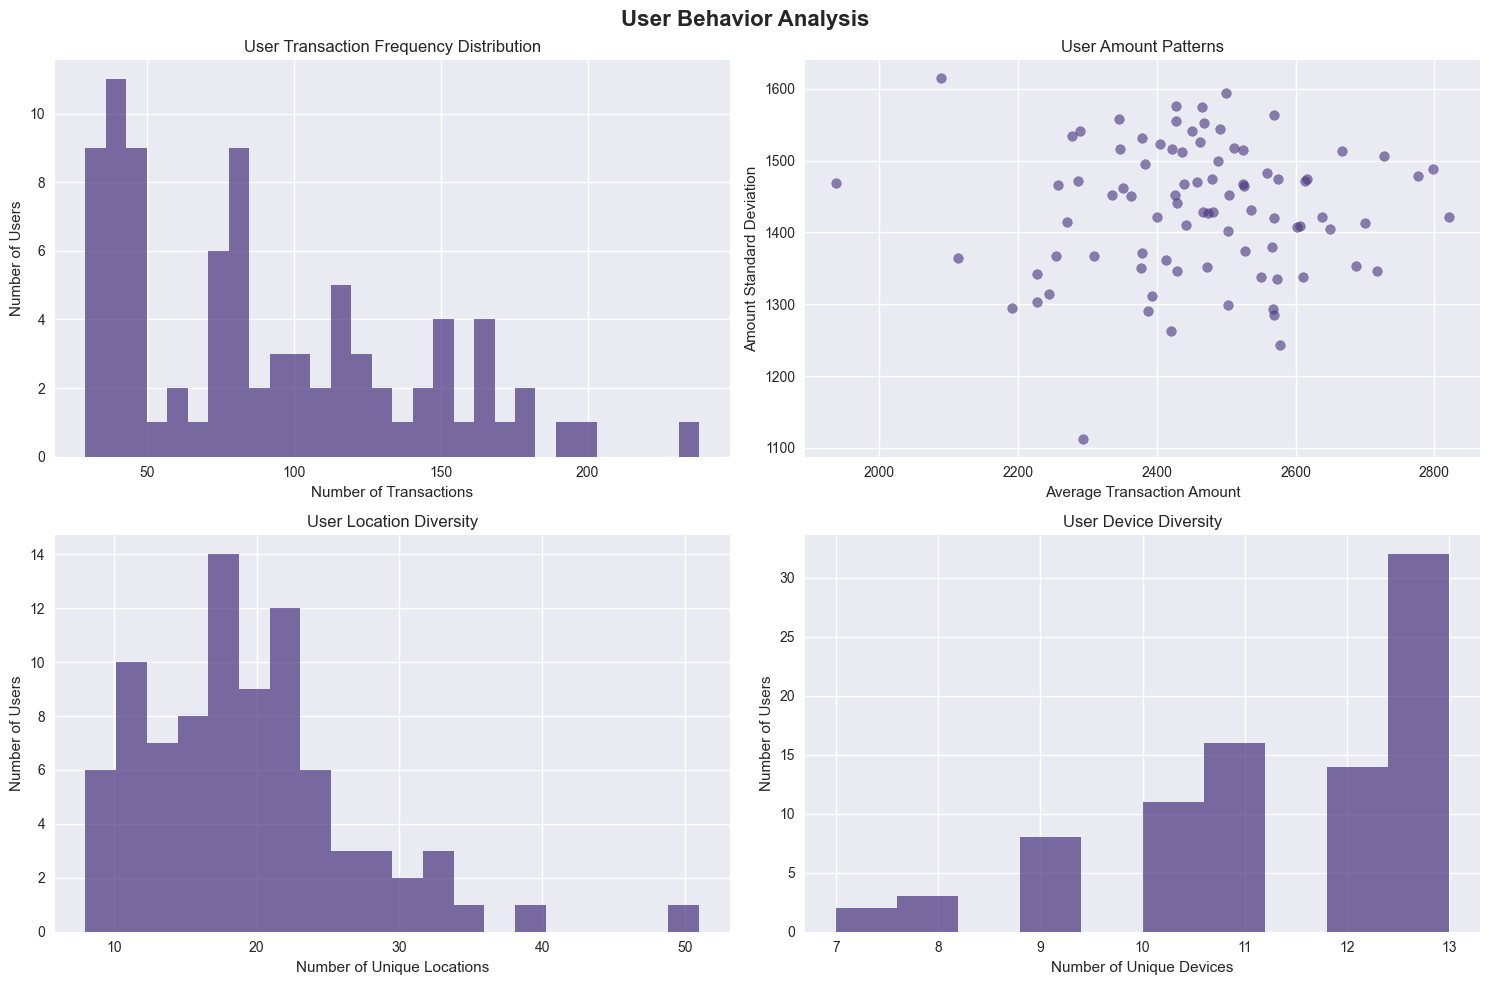

💾 User behavior analysis saved to results/user_behavior_analysis.png


In [ ]:
# User behavior analysis
fig = viz.plot_user_behavior_analysis(df_valid)
plt.show()

# Save the figure
fig.savefig('../results/user_behavior_analysis.png', dpi=300, bbox_inches='tight')
print("💾 User behavior analysis saved to results/user_behavior_analysis.png")

In [ ]:
# User statistics
print("👤 User Statistics:")
print("=" * 30)

user_stats = df_valid.groupby('user_id').agg({
    'amount': ['count', 'mean', 'std', 'min', 'max'],
    'location': 'nunique',
    'device': 'nunique',
    'transaction_type': 'nunique'
}).round(2)

user_stats.columns = ['tx_count', 'avg_amount', 'std_amount', 'min_amount', 'max_amount', 
                     'unique_locations', 'unique_devices', 'unique_types']

print("Summary statistics for all users:")
print(user_stats.describe())

print("\nTop 10 most active users:")
print(user_stats.sort_values('tx_count', ascending=False).head(10))

👤 User Statistics:
Summary statistics for all users:
         tx_count   avg_amount   std_amount  min_amount   max_amount  \
count   86.000000    86.000000    86.000000   86.000000    86.000000   
mean    90.395349  2459.733721  1432.683140   84.963256  4911.614767   
std     49.988300   157.319571    92.636604  119.338182   107.081532   
min     29.000000  1937.030000  1112.700000    1.620000  4449.640000   
25%     44.000000  2378.070000  1365.447500   18.075000  4875.702500   
50%     80.000000  2465.820000  1445.875000   45.575000  4957.040000   
75%    120.750000  2567.380000  1504.880000   87.257500  4982.165000   
max    238.000000  2821.430000  1614.520000  733.390000  4998.250000   

       unique_locations  unique_devices  unique_types  
count         86.000000       86.000000     86.000000  
mean          19.360465       11.395349      8.802326  
std            7.389838        1.646951      0.480680  
min            8.000000        7.000000      7.000000  
25%           14.0

## 7. Amount Analysis

💵 Amount Analysis:
Amount statistics:
count    7774.000000
mean     2479.183189
std      1441.023290
min         1.620000
25%      1231.760000
50%      2464.385000
75%      3741.262500
max      4998.250000
Name: amount, dtype: float64


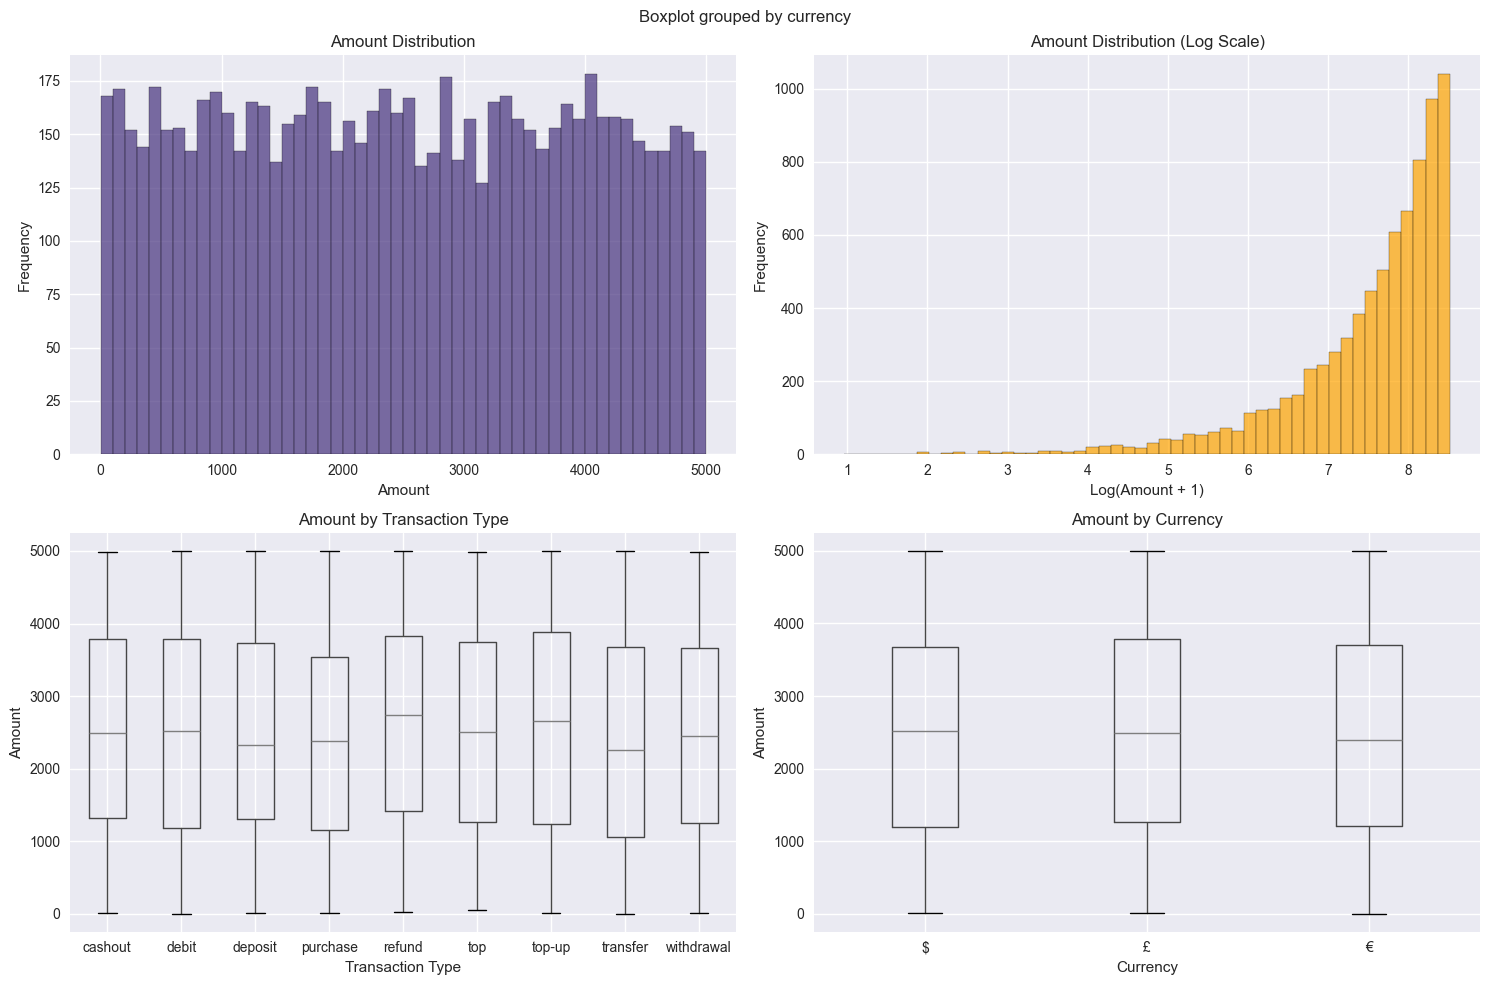

💾 Amount analysis saved to results/amount_analysis.png


In [ ]:
# Amount distribution analysis
print("💵 Amount Analysis:")
print("=" * 25)

amount_stats = df_valid['amount'].describe()
print("Amount statistics:")
print(amount_stats)

# Plot amount distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Transaction Amount Analysis', fontsize=16, fontweight='bold')

# Histogram
axes[0, 0].hist(df_valid['amount'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Amount Distribution')
axes[0, 0].set_xlabel('Amount')
axes[0, 0].set_ylabel('Frequency')

# Log scale histogram
axes[0, 1].hist(np.log1p(df_valid['amount']), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].set_title('Amount Distribution (Log Scale)')
axes[0, 1].set_xlabel('Log(Amount + 1)')
axes[0, 1].set_ylabel('Frequency')

# Box plot by transaction type
df_valid.boxplot(column='amount', by='transaction_type', ax=axes[1, 0])
axes[1, 0].set_title('Amount by Transaction Type')
axes[1, 0].set_xlabel('Transaction Type')
axes[1, 0].set_ylabel('Amount')

# Box plot by currency
df_valid.boxplot(column='amount', by='currency', ax=axes[1, 1])
axes[1, 1].set_title('Amount by Currency')
axes[1, 1].set_xlabel('Currency')
axes[1, 1].set_ylabel('Amount')

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('../results/amount_analysis.png', dpi=300, bbox_inches='tight')
print("💾 Amount analysis saved to results/amount_analysis.png")

## 8. Save Processed Data

In [ ]:
# Create results directory
os.makedirs('../results', exist_ok=True)

# Save processed data
df_valid.to_csv('../results/parsed_transactions.csv', index=False)
print(f"💾 Parsed transactions saved: {len(df_valid):,} records")

# Save parsing statistics
import json
with open('../results/parsing_stats.json', 'w') as f:
    # Convert datetime objects to strings for JSON serialization
    json_stats = parsing_stats.copy()
    json.dump(json_stats, f, indent=2)
print("💾 Parsing statistics saved")

print("\n✅ Data exploration complete!")
print(f"Ready for feature engineering with {len(df_valid):,} clean transactions")

💾 Parsed transactions saved: 7,774 records
💾 Parsing statistics saved

✅ Data exploration complete!
Ready for feature engineering with 7,774 clean transactions


## Summary

### Key Findings:
1. **Parsing Success**: Our robust parser achieved a high success rate in handling multiple log formats
2. **Data Quality**: The parsed dataset shows good completeness across key fields
3. **Temporal Patterns**: Clear patterns in transaction timing and user behavior
4. **User Diversity**: Wide variety in user transaction patterns and amounts
5. **Business Context**: Data represents realistic financial transaction patterns

### Next Steps:
1. Feature engineering based on discovered patterns
2. Behavioral modeling for anomaly detection
3. Implementation of multiple detection approaches
4. Model evaluation and optimization